# 🤒 Epidemic Mitigation Simulation

Our group project for the CS-456: Artificial Neural Networks/Reinforcement Learning course.

Team Member 1

> - 😀 Name: **Yiyang Feng**
> - ✉️ Email: **yiyang.feng@epfl.ch**
> - 🪪 SCIPER: **352042**

Team Member 2

> - 😀 Name: **Jiayi Sun**
> - ✉️ Email: **jiayi.sun@epfl.ch**
> - 🪪 SCIPER: **366961**

In [1]:
# Matplotlib imports
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import ScalarFormatter

# Openai gym imports
from gym import spaces

# Environment imports
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

# Pytorch and numpy imports
import numpy as np
import torch
from torch import nn

import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Constants
SEED = 42
SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4

In [4]:
def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = {
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])    # percentage of infected people in each city
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])            # percentage of dead people in each city
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

In [5]:
# Load the switzerland map
dyn = ModelDynamics('config/switzerland.yaml')

# Load the action space and the observation space
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

## Question 1: Study the behavior of the model when epidemics are unmitigated

Run the epidemic simulation for one episode (30 weeks), without epidemic mitigation (meaning no action is taken, i.e. all values in the action dictionary are set to False).

In [6]:
# Load the environment
env = Env(dyn)

In [7]:
# Run the epidemic simulation for one episode (30 weeks) without any mitigation measures

weeks = 30
log = []

# Set the seed
obs, info = env.reset(SEED)

for _ in range(weeks):
    # Set all actions to False (no mitigation)
    action = {
        'confinement': False,
        'isolation': False,
        'vaccinate': False,
        'hospital': False,
    }
    
    # Perform one step in the environment
    obs, reward, done, info = env.step(action)

    # Collect data
    log.append(info)

In [8]:
# Parse the logs
total = {p: np.array([getattr(l.total, p) for l in log]) for p in dyn.parameters}
cities = {c: {p: np.array([getattr(l.city[c], p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a: np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

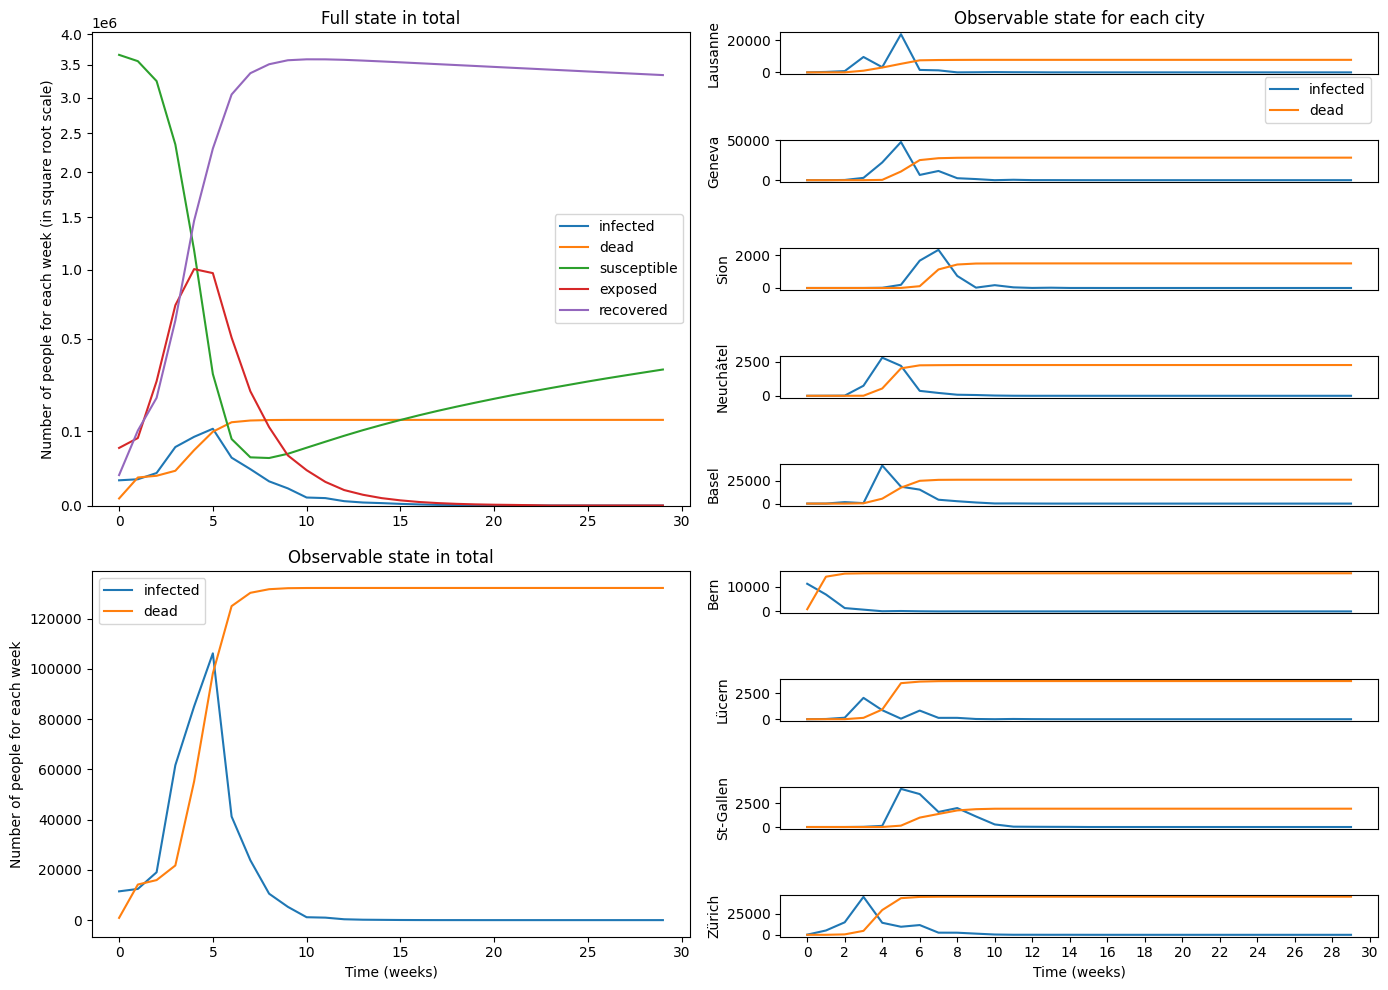

In [9]:
# Set the figure and the axes
fig = plt.figure(figsize=(14, 10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=5)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(5, 0), rowspan=4)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1, 9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

# 1.1 A plot of variables s[w] total, e[w] total, i[w] total, r[w] total, d[w] total over time
[ax_leftstate.plot(y) for key, y in total.items() if key != "initial_population"]
ax_leftstate.legend([key for key in total.keys() if key != "initial_population"])
ax_leftstate.set_title('Full state in total')
ax_leftstate.set_ylabel('Number of people for each week (in square root scale)')
ax_leftstate.set_yscale('function', functions=(np.sqrt, np.square))
ax_leftstate.yaxis.set_major_formatter(ScalarFormatter())
ax_leftstate.set_yticks([0, 0.1e6, 0.5e6, 1e6, 1.5e6, 2e6, 2.5e6, 3e6, 3.5e6, 4e6])

# 1.2 A plot of variables i[w] total, d[w] total over time
[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state in total')
ax_leftobs.set_ylabel('Number of people for each week')
ax_leftobs.set_xlabel('Time (weeks)')

# 1.3 A set of plots of variables i[w] city, d[w] city over time (one subplot per-city)
infected_line = ax_right["Zürich"].plot(cities["Zürich"]['infected'], label="infected")[0]
dead_line = ax_right["Zürich"].plot(cities["Zürich"]['dead'], label="dead")[0]

for c, ax in ax_right.items():
    if c != "Zürich":
        ax.plot(cities[c]['infected'])
        ax.plot(cities[c]['dead'])

[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Lausanne'].set_title('Observable state for each city')
ax_right['Zürich'].set_xlabel('Time (weeks)')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

# Add a single overall legend for subplots in ax_right
legend = ax_right["Lausanne"].legend([infected_line, dead_line], ["infected", "dead"], loc="upper right", bbox_to_anchor=(1, 0.1))

fig.tight_layout()
plt.show()

## Question 2: Implement Pr. Russo’s Policy

### 2.a Implement Pr. Russo’s Policy as a python class and produce four plots

In [10]:
class RussoPolicyAgent(Agent):
    def __init__(self):
        self.confine_until = None
        self.current_week = 0

    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass

    def act(self, obs):
        infected_total = obs.total.infected[-1]

        # Check if we are still in confinement period
        if self.confine_until is not None and self.current_week < self.confine_until:
            return {'confinement': True, 'isolation': False, 'vaccinate': False, 'hospital': False}
        
        if infected_total > 20000:
            self.confine_until = self.current_week + 4
            return {'confinement': True, 'isolation': False, 'vaccinate': False, 'hospital': False}
        
        self.confine_until = None
        return {'confinement': False, 'isolation': False, 'vaccinate': False, 'hospital': False}

In [11]:
# Run the epidemic simulation for one episode with Pr. Russo's policy
weeks = 30
log = []

# Set the seed
obs, info = env.reset(SEED)

agent = RussoPolicyAgent()

for week in range(weeks):
    agent.current_week = week
    action = agent.act(obs)
    obs, reward, done, info = env.step(action)
    log.append(info)

In [12]:
# Parse the logs
total = {p: np.array([getattr(l.total, p) for l in log]) for p in dyn.parameters}
cities = {c: {p: np.array([getattr(l.city[c], p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a: np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

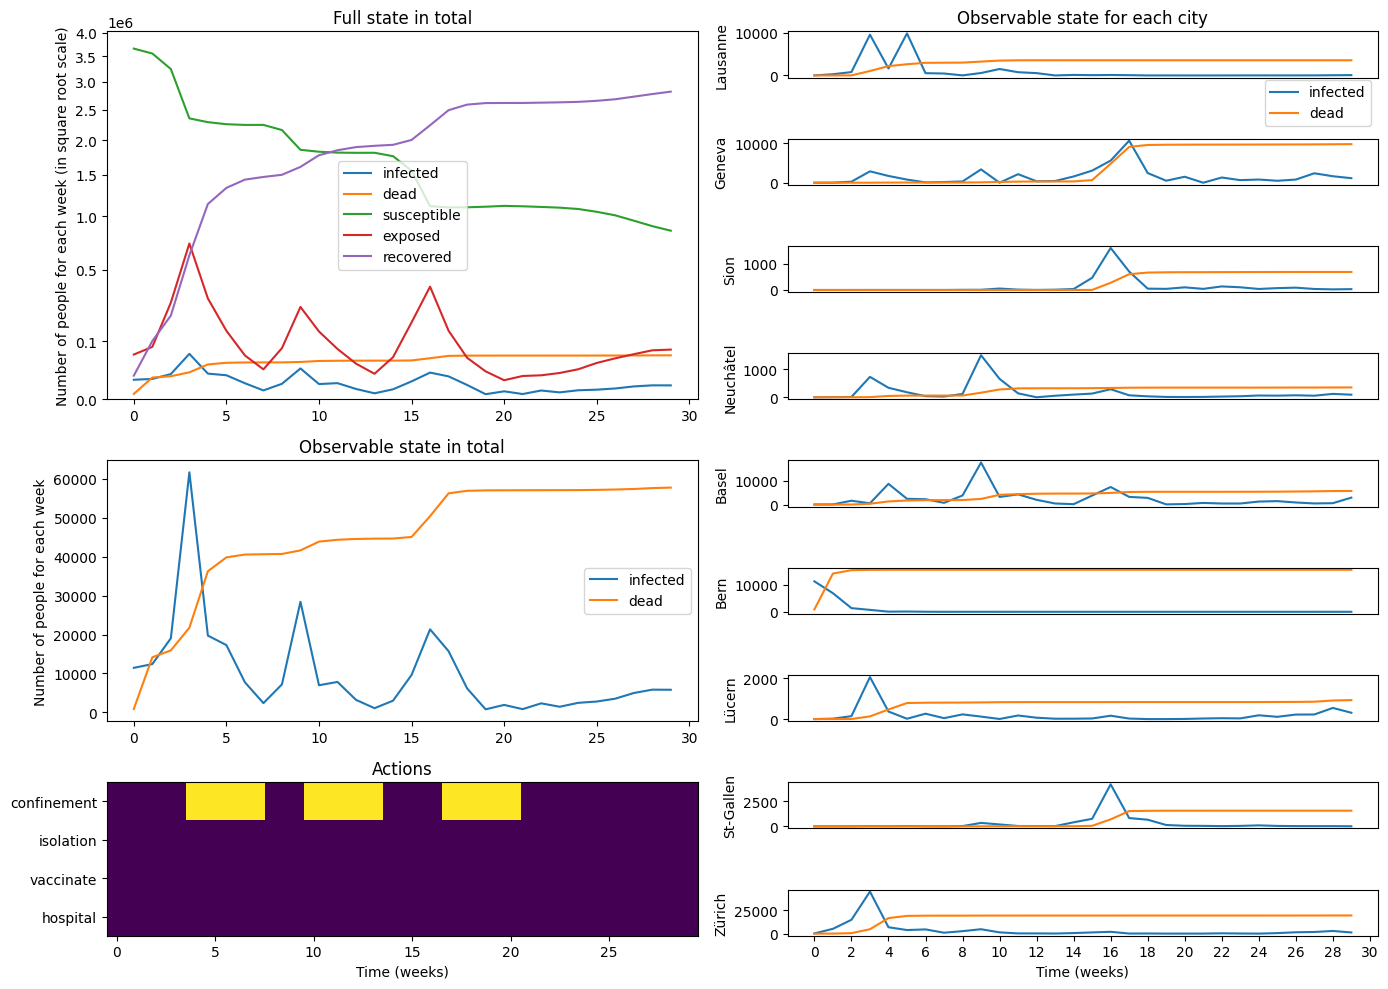

In [13]:
# Set the figure and the axes
fig = plt.figure(figsize=(14, 10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1, 9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

# 2.a.1 A plot of variables s[w] total, e[w] total, i[w] total, r[w] total, d[w] total over time
[ax_leftstate.plot(y) for key, y in total.items() if key != "initial_population"]
ax_leftstate.legend([key for key in total.keys() if key != "initial_population"])
ax_leftstate.set_title('Full state in total')
ax_leftstate.set_ylabel('Number of people for each week (in square root scale)')
ax_leftstate.set_yscale('function', functions=(np.sqrt, np.square))
ax_leftstate.yaxis.set_major_formatter(ScalarFormatter())
ax_leftstate.set_yticks([0, 0.1e6, 0.5e6, 1e6, 1.5e6, 2e6, 2.5e6, 3e6, 3.5e6, 4e6])

# 2.a.2 A plot of variables i[w] total, d[w] total over time
[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state in total')
ax_leftobs.set_ylabel('Number of people for each week')

# 2.a.4 A plot of the action taken by the policy over time
ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('Time (weeks)')

# 2.a.3 A set of plots of variables i[w] city, d[w] city over time (one subplot per-city)
infected_line = ax_right["Zürich"].plot(cities["Zürich"]['infected'], label="infected")[0]
dead_line = ax_right["Zürich"].plot(cities["Zürich"]['dead'], label="dead")[0]

for c, ax in ax_right.items():
    if c != "Zürich":
        ax.plot(cities[c]['infected'])
        ax.plot(cities[c]['dead'])

[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Lausanne'].set_title('Observable state for each city')
ax_right['Zürich'].set_xlabel('Time (weeks)')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

# Add a single overall legend for subplots in ax_right
legend = ax_right["Lausanne"].legend([infected_line, dead_line], ["infected", "dead"], loc="upper right", bbox_to_anchor=(1, 0.1))

fig.tight_layout()
plt.show()

### Question 2.b Evaluate Pr. Russo’s Policy

In [14]:
# Set the number of episodes
n_episodes = 50

In [15]:
# Evaluate policy that can be reusable
def evaluate_policy(agent_class, env, n_episodes=50, seeds=None, weeks=30):
    N_confinement = []
    R_cumulative = []
    N_deaths = []
    
    for episode in range(n_episodes):
        agent = agent_class()
        if seeds is not None:
            seed = seeds[episode]
        else:
            seed = np.random.randint(1, 1e5)
        
        obs, info = env.reset(seed.item())
        # obs, info = env.reset(55569)
        log = []
        total_reward = 0
        
        for week in range(weeks):
            agent.current_week = week
            action = agent.act(obs)
            obs, reward, done, info = env.step(action)
            log.append(info)
            total_reward += reward.item()

        total_confined_weeks = sum([1 for l in log if l.action['confinement']])
        N_confinement.append(total_confined_weeks * 7)
        R_cumulative.append(total_reward)
        N_deaths.append(log[-1].total.dead)

    return N_confinement, R_cumulative, N_deaths

In [16]:
# Set a deterministic sequence of seeds
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)
seeds = torch.randint(1, int(1e5), (n_episodes,))

In [17]:
# Run the evaluation procedure for Pr. Russo's policy
N_confinement, R_cumulative, N_deaths = evaluate_policy(RussoPolicyAgent, env, n_episodes=50, seeds=seeds)

In [18]:
# Plot histograms with the average number (in red lines)
def plot_histogram_with_avg(ax, data, title):
    ymax = 50
    if title == 'Deaths':
        x_range = (1000, 200000)
    elif title == 'Cumulative Rewards': 
        x_range = (-300, 300)
    elif 'Days' in title:
        x_range = (0, 200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0, ymax)
    ax.vlines([np.mean(data)], 0, ymax, color='red')
    ax.hist(data, bins=60, range=x_range)

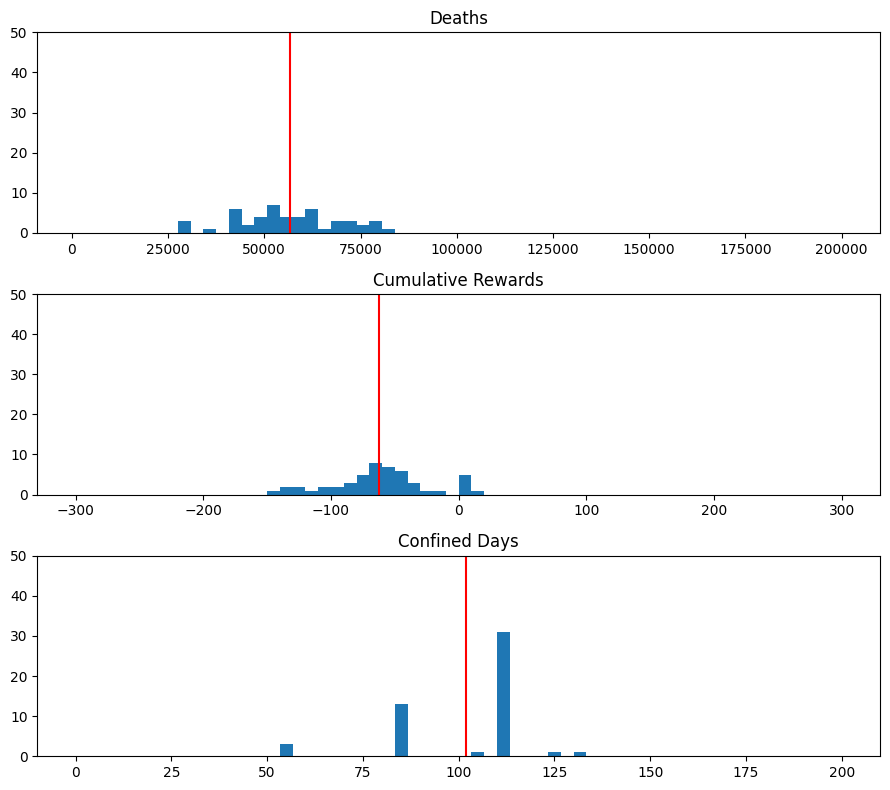

In [19]:
# Set figure size
fig, ax = plt.subplots(3, 1, figsize=(9, 8))

# Plot histograms for N_confinement, R_cumulative, and N_deaths
plot_histogram_with_avg(ax[0], N_deaths, 'Deaths')
plot_histogram_with_avg(ax[1], R_cumulative, 'Cumulative Rewards')
plot_histogram_with_avg(ax[2], N_confinement, 'Confined Days')
fig.tight_layout()
plt.show()